# Baseline Model and Pipeline for Hit-Predict Project

## Problem Statement

Predicting a song's popularity is mutually beneficial for both the industry and its consumers. Record labels and streaming platforms are interested in which songs to promote and prioritize, and consumers want to discover songs they connect with and enjoy. This project therefore seeks to answer the question: **What factors most strongly influence a song's popularity, and how can they be leveraged to accurately predict it?**

This project focuses on predicting the popularity of songs from the streaming service Spotify based on audio features, artist information, and other relevant metadata. The goal is to build a model and that provides robust predictions on the popularity of songs.

Predicting track popularity requires analyzing patterns in song attributes to understand its influences. Key features to consider include song characteristics like danceability, energy, loudness, and genre. 

The challenge with predicting popularity is that popularity distribution is heavily skewed; in other words, not many songs become hits. Particularly with streaming services, it is easy to upload your own songs which results in many tracks having zero popularity. This imbalanced distribution may introduce bias in training models if not handled appropriately.

## Table of Contents
1. [Setup](#setup)
    - [Importing Libraries](#lib)
    - [Loading Data](#data)
2. [EDA](#eda)
3. [Baseline Models](#baseline)
    - [Regression Problem](#sub1)
    - [Classification Problem with Classes by 20](#sub2)
    - [Classification Problem with Classes by 5](#sub3)
4. [Final Model Pipeline](#pipeline)

## 1. Setup
<a id="setup"></a>

### Importing Libraries
<a id="lib"></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Loading Data
<a id="data"></a>

Loading three dataframes, each of which encode the imbalanced data in different ways. We will explore this imbalance in our EDA and decide which encoding works best for our model in the baseline modelling section.

In [3]:
DATA_PATH_nothing = "../data/processed_spotify_songs.csv"
df_nothing = pd.read_csv(DATA_PATH_nothing)

DATA_PATH_0mean = "../data/0mean_data.csv"
df_0mean = pd.read_csv(DATA_PATH_0mean)

DATA_PATH_no0 = "../data/no0_data.csv"
df_no0 = pd.read_csv(DATA_PATH_no0)

#### Drop non-numerical data

# to do: explain why we drop this data

In [4]:
df_nothing = df_nothing.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre"])
df_0mean = df_0mean.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre"])
df_no0 = df_no0.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre"])

## 2. Explore and visualize data
<a id="eda"></a>

We will conduct exploratory data analysis to understand the underlying trends in the data using the pre-processed data. As discussed in the problem statement, the data is inherently skewed. Alongside exploring the variables, we will visualize this skewness, as well as various different ways to deal with this imbalance in the data.

### Exploration of Variables
<a id="sub1"></a>

**Categorical variables:** track_artist, track_album_id, track_album_release_date, playlist_id, playlist_subgenre, key, playlist_genre, pop, hip hop, metal, rock, edm, r&b, latin.

**Quantitative variables:** track_popularity, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo, artist_track_encoded, playlist_id_encoded, track_album_id_encoded, release_year, release_month, release_day.

In [23]:
df_nothing.describe().T

,count,mean,std,min,25%,50%,75%,max
track_popularity,28352.0,39.335320,23.699443,0.000000,21.000000,42.000000,58.000000,100.000000
danceability,28352.0,0.463788,0.188308,0.000000,0.325701,0.464561,0.597751,1.000000
energy,28352.0,0.521398,0.238359,0.000000,0.335241,0.521284,0.710649,1.000000
key,28352.0,5.367417,3.613743,0.000000,2.000000,6.000000,9.000000,11.000000
loudness,28352.0,0.699150,0.099062,0.000000,0.645094,0.714462,0.769362,1.000000
mode,28352.0,0.565533,0.495696,0.000000,0.000000,1.000000,1.000000,1.000000
speechiness,28352.0,0.453648,0.127350,0.000000,0.354797,0.408549,0.525214,1.000000
acousticness,28352.0,0.449806,0.248615,0.000000,0.243211,0.431212,0.639532,1.000000
instrumentalness,28352.0,0.175032,0.289067,0.000000,0.000000,0.027490,0.187693,1.000000
liveness,28352.0,0.544491,0.131413,0.000000,0.453020,0.503325,0.629961,1.000000


#### Distribution of the Target Variable (Track Popularity)

The target variable, `track_popularity`, is skewed and has many zero values. These zero values indicate songs with no popularity on the platform. Handling these variables is appropriately is important to avoid bias. In the plot below, we can see the distribution of `track_popularity` when the skewness is being handled in three different ways. 

The plot the left-hand side displays the distribution of `track_popularity` if we were to make no changes. This plot demonstrates the skewness present in the target variable before any transformations.

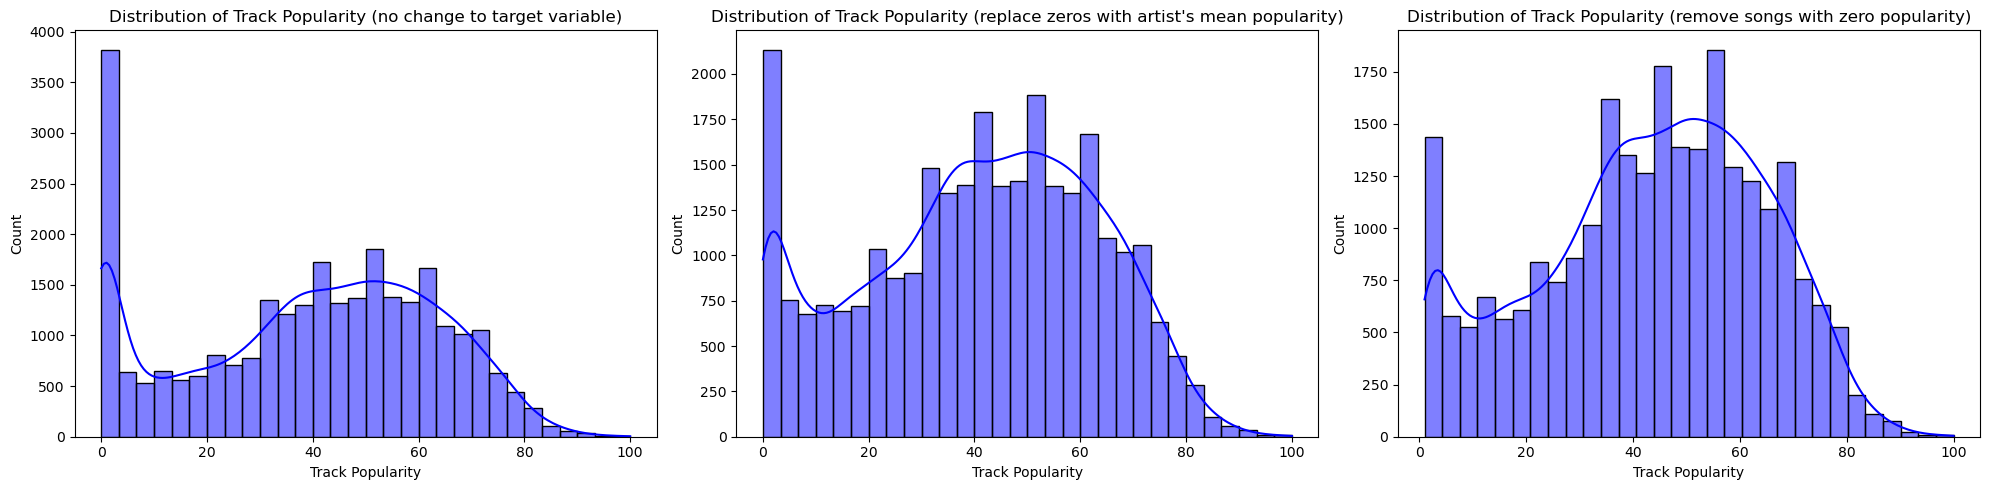

In [18]:
# plot histogram of track popularity for different ways of handling zero values
fig, axes = plt.subplots(1, 3, figsize=(20, 5)) # 3 rows 1 column

sns.histplot(df_nothing["track_popularity"], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Distribution of Track Popularity (no change to target variable)")
axes[0].set_xlabel("Track Popularity")
axes[0].set_ylabel("Count")

sns.histplot(df_0mean["track_popularity"], bins=30, kde=True, color='blue', ax=axes[1])
axes[1].set_title("Distribution of Track Popularity (replace zeros with artist's mean popularity)")
axes[1].set_xlabel("Track Popularity")
axes[1].set_ylabel("Count")

sns.histplot(df_no0["track_popularity"], bins=30, kde=True, color='blue', ax=axes[2])
axes[2].set_title("Distribution of Track Popularity (remove songs with zero popularity)")
axes[2].set_xlabel("Track Popularity")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Each of the plots above show the resulting distribution of the plots when considering three different ways to handle the large number of zero popularity tracks:
- Retain zero-popularity values as they are, with no transformation 
- Replace zero values with the artist’s mean popularity (excluding songs with zero popularity, unless all songs have zero)
- Remove zero-popularity songs from the dataset

As we can see from the plots above, the second and third options reduce the skew. When replacing zeros with the artist's mean popularity, some zero values still remain, demonstrating that there are numerous artists where all there songs have zero popularity.

When removing all the zero popularity songs, we see that the next bin also has a lot of values representing songs with very low popularity. This again is not ideal and we might need to account for this in our analysis. When considering this option, we want to keep in mind that the ideal situation would be to have a normal distribution of the track popularity values.

We will consider all three of these options in our baseline model to understand the impact of each on the models.

#### Distribution of the Numeric Predictor Variables

In the data pre-processing, we scaled and corrected the skewness of the quantitative variables. We can see their resulting distributions in the plots below.

Although several predictors including `instrumentalness` and `speechiness` remain imbalanced after scaling, the majority of predictors now follow a normal distribution. 

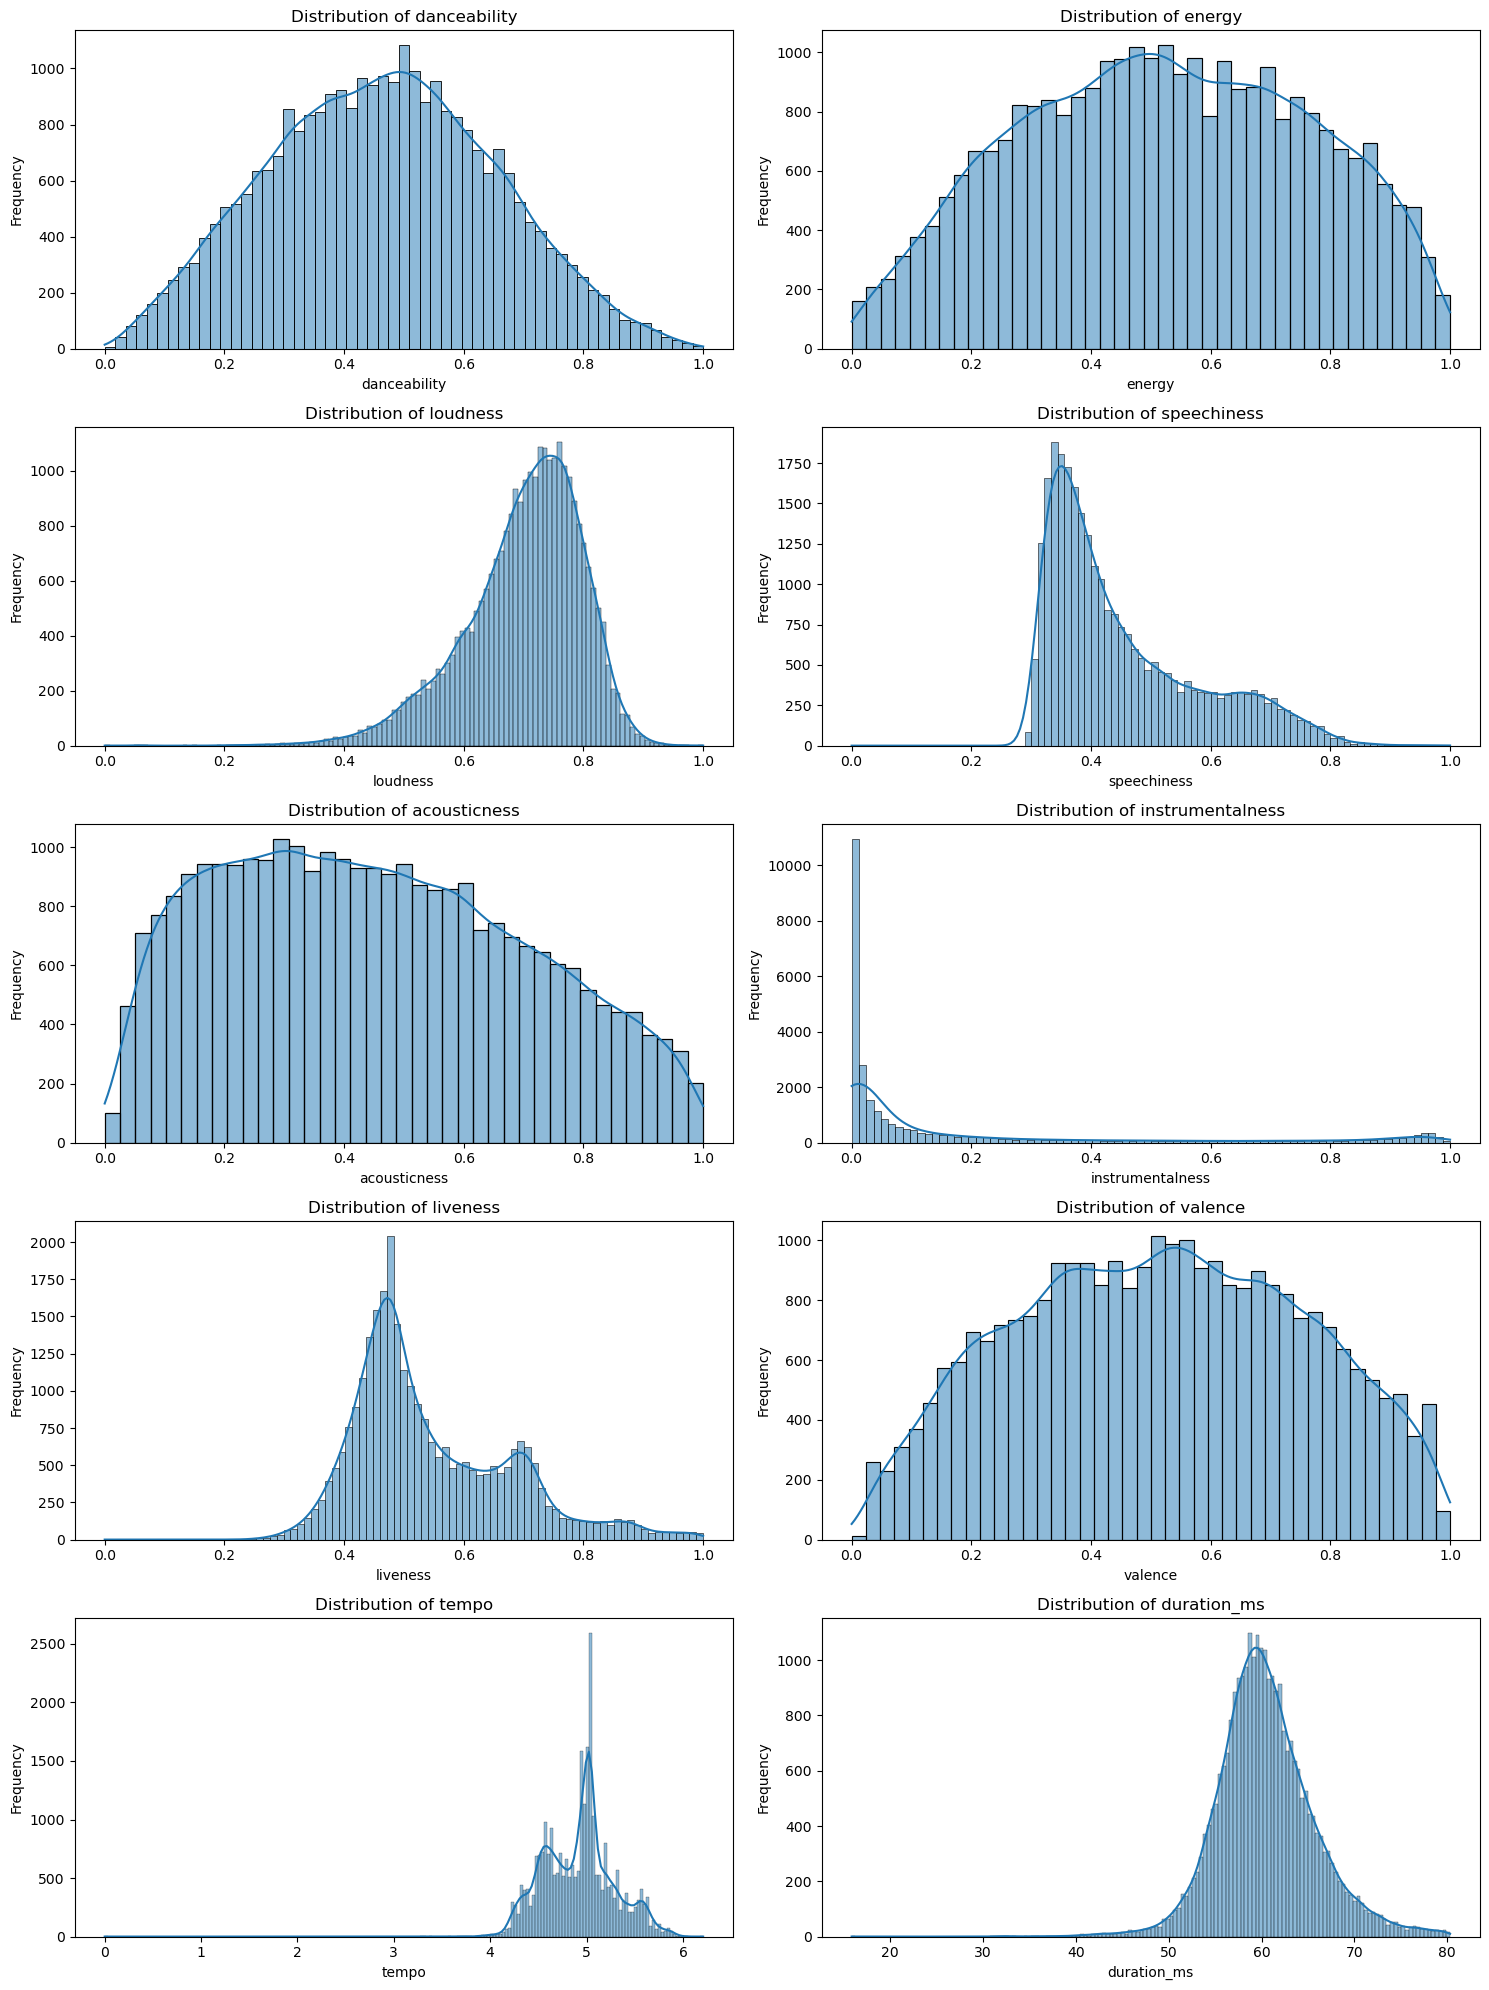

In [25]:
numeric_columns = ["danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
]

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df_nothing[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)  
    plt.ylabel("Frequency")  
plt.tight_layout()
plt.show()

#### Distribution of the Categorical Predictor Variables

We then analyzed the categorical variables to look for any anomalies in the data. From the plot below, we can see that all genres are well-represented across the dataset and that there is no class imbalance. 

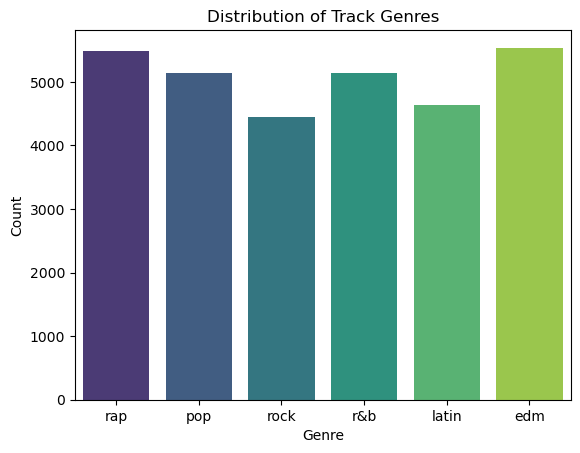

In [30]:
genre_columns = ["rap", "pop", "rock", "r&b", "latin", "edm"]
genre_data = df_nothing[genre_columns]

genre_counts = genre_data.sum().reset_index()
genre_counts.columns = ['Genre', 'Count']  

sns.barplot(data=genre_counts, x='Genre', y='Count', hue='Genre', palette="viridis", legend=False)
plt.title("Distribution of Track Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

#### Distribution of Temporal Variables

Lastly, we investigated the distributions of the temporal variables in our dataset.

When analyzing the plots below, we found that the dataset contains many more observations of recent tracks. This could be beneficial in our case as it may mean current trends are captured more accurately and we are interested in predicting future hits. The distribution of `release month` is fairly similar across all months except for January where there is a significant spike. When combining this observation with the trends in `day of month` which show an overwhelming number of tracks released on the 1st, it might be the case that the default date imputed when the date was missing was January 1st. When carrying out our analysis, we will keep this in mind to ensure that potentially imputed values do not affect the prediction.

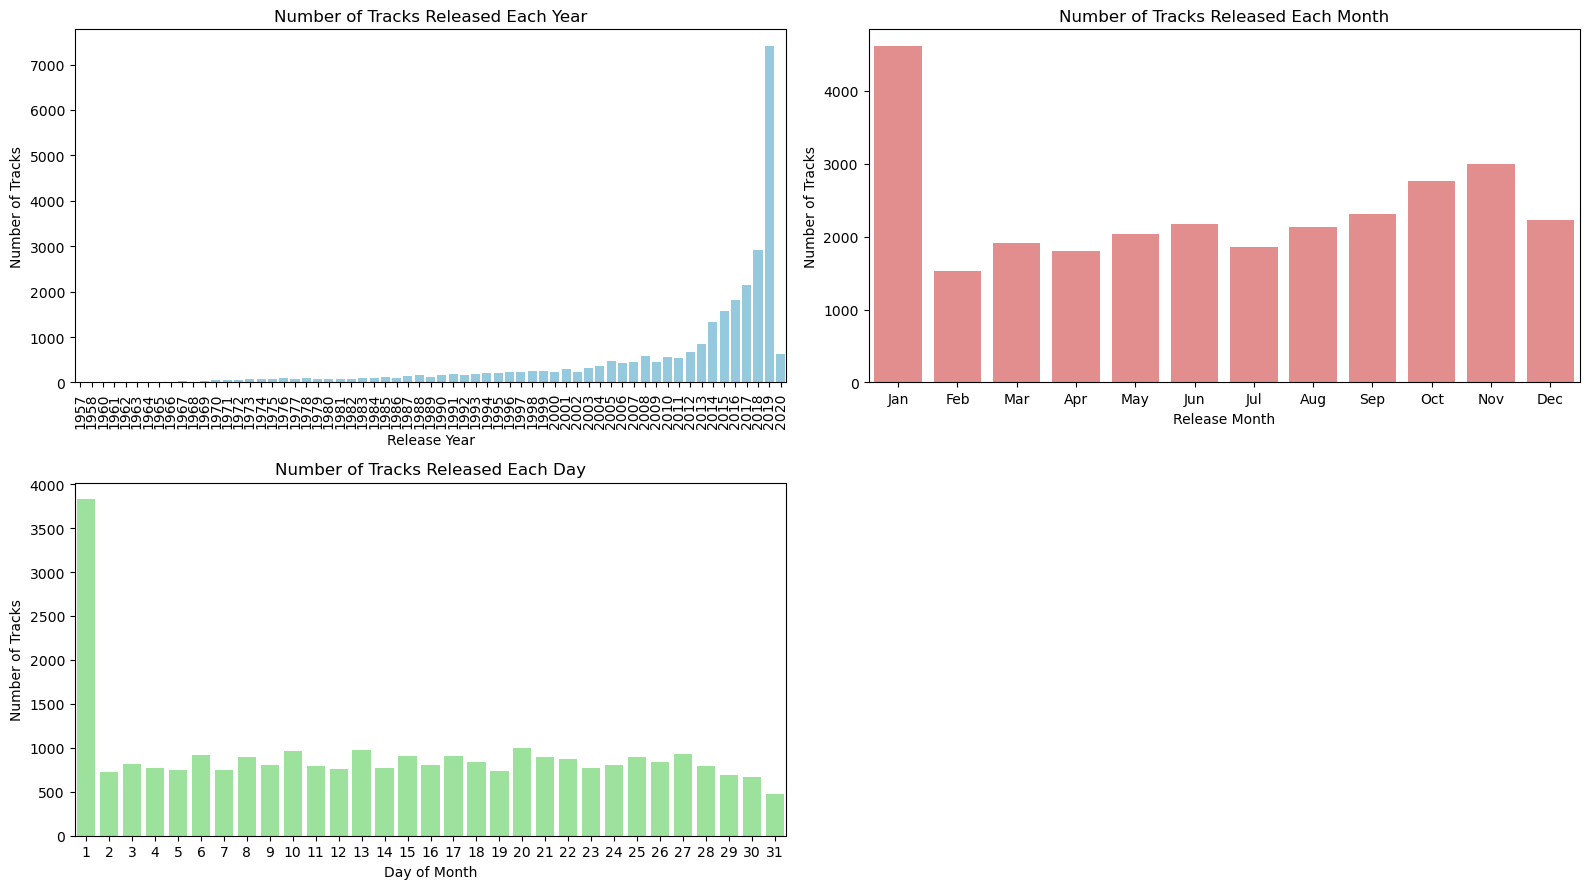

In [37]:
tracks_per_year = df_nothing['release_year'].value_counts().sort_index()
tracks_per_month = df_nothing['release_month'].value_counts().sort_index()
tracks_per_day = df_nothing['release_day'].value_counts().sort_index()

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

# plotting release year distribution
sns.barplot(x=tracks_per_year.index, y=tracks_per_year.values, color="skyblue", ax=axs[0, 0])
axs[0, 0].set_title("Number of Tracks Released Each Year")
axs[0, 0].set_xlabel("Release Year")
axs[0, 0].set_ylabel("Number of Tracks")
axs[0, 0].tick_params(axis='x', rotation=90)

# release month distribution
sns.barplot(x=tracks_per_month.index, y=tracks_per_month.values, color="lightcoral", ax=axs[0, 1])
axs[0, 1].set_title("Number of Tracks Released Each Month")
axs[0, 1].set_xlabel("Release Month")
axs[0, 1].set_ylabel("Number of Tracks")
axs[0, 1].set_xticks(range(12))
axs[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)

# release day distribution
sns.barplot(x=tracks_per_day.index, y=tracks_per_day.values, color="lightgreen", ax=axs[1, 0])
axs[1, 0].set_title("Number of Tracks Released Each Day")
axs[1, 0].set_xlabel("Day of Month")
axs[1, 0].set_ylabel("Number of Tracks")

fig.delaxes(axs[1, 1])  # remove empty fourth plot

plt.tight_layout()
plt.show()

### Relationship between Track Popularity and Predictor Variables

As we can see from the plots below, there is no clear relationship between any of the quantitative nor categorical predictors and track popularity.

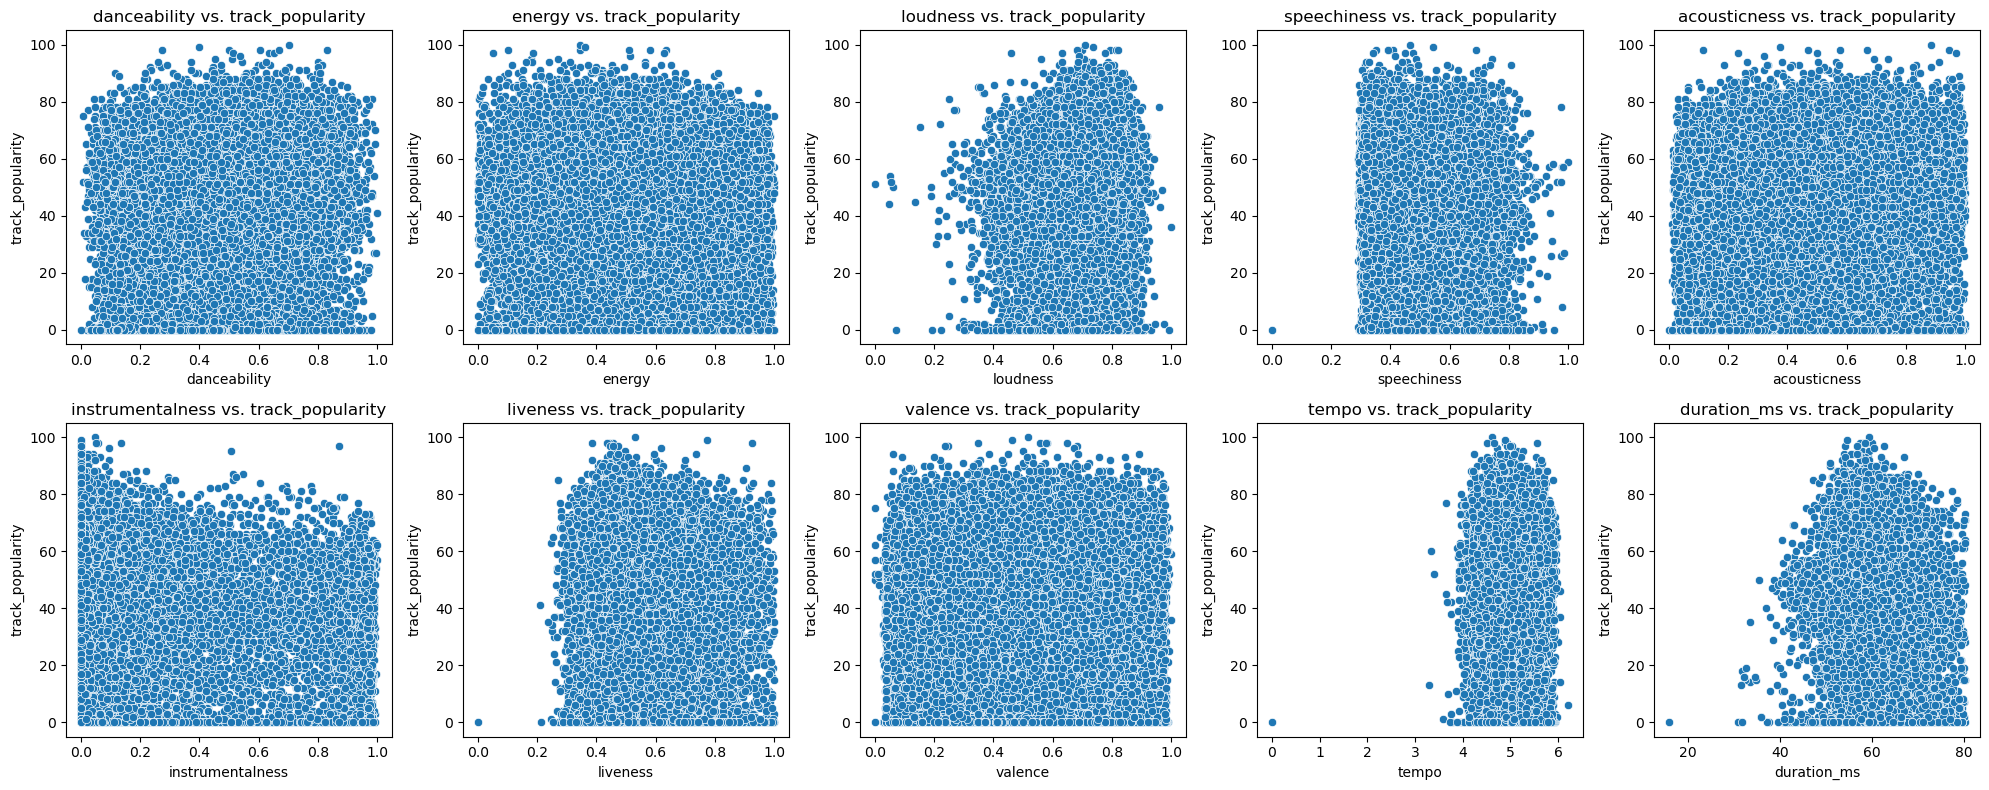

In [43]:
plt.figure(figsize=(20, 8))  
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 5, i)  # 2 rows and 5 columns
    sns.scatterplot(data=df_nothing, x=column, y="track_popularity")
    plt.title(f"{column} vs. track_popularity")
    plt.xlabel(column) 
    plt.ylabel("track_popularity") 

plt.tight_layout()
plt.show()

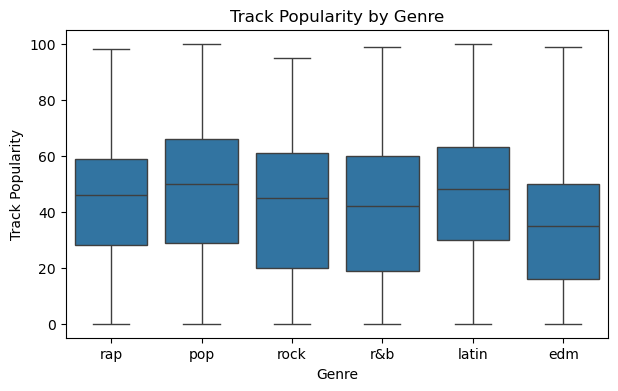

In [44]:
data_melted = df_nothing.melt(id_vars=["track_popularity"], value_vars=genre_columns, 
                        var_name="Genre", value_name="Is_Present")

data_genre = data_melted[data_melted["Is_Present"] == 1]

plt.figure(figsize=(7, 4))
sns.boxplot(data=data_genre, x="Genre", y="track_popularity")
plt.title("Track Popularity by Genre")
plt.xlabel("Genre")
plt.ylabel("Track Popularity")
plt.show()

Similarly, when analyzing the relationship between the temporal variables and the target variable we find no clear relationship. This was slightly
surprising as we might expect specific days such as Christmas or ‘summer songs’ months to influence a song’s popularity. 

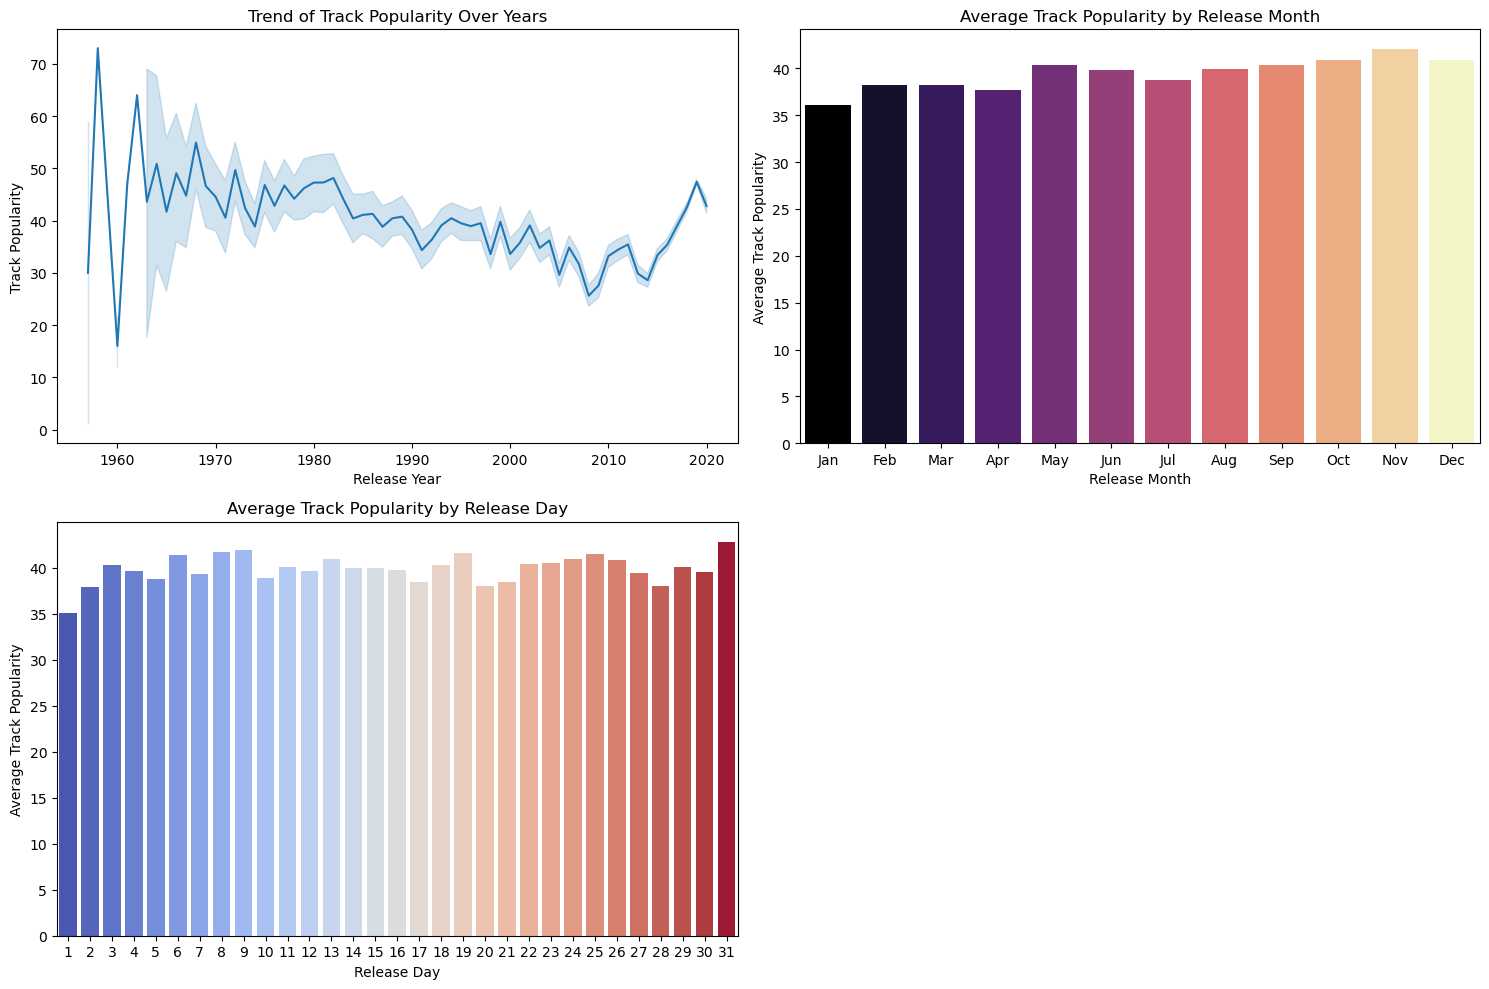

In [49]:
popularity_by_month = df_nothing.groupby('release_month')['track_popularity'].mean().reset_index()
popularity_by_day = df_nothing.groupby('release_day')['track_popularity'].mean().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust figsize for better readability

# Plot trend of track popularity over years
sns.lineplot(data=df_nothing, x="release_year", y="track_popularity", errorbar=('ci', 95), ax=axs[0, 0])
axs[0, 0].set_title("Trend of Track Popularity Over Years")
axs[0, 0].set_xlabel("Release Year")
axs[0, 0].set_ylabel("Track Popularity")

# Plot track popularity by release month
sns.barplot(data=popularity_by_month, x="release_month", y="track_popularity", hue="release_month", palette="magma", ax=axs[0, 1], dodge=False, legend=False)
axs[0, 1].set_title("Average Track Popularity by Release Month")
axs[0, 1].set_xlabel("Release Month")
axs[0, 1].set_ylabel("Average Track Popularity")
axs[0, 1].set_xticks(range(12))
axs[0, 1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Plot track popularity by release day
sns.barplot(data=popularity_by_day, x="release_day", y="track_popularity", hue="release_day", palette="coolwarm", ax=axs[1, 0], dodge=False, legend=False)
axs[1, 0].set_title("Average Track Popularity by Release Day")
axs[1, 0].set_xlabel("Release Day")
axs[1, 0].set_ylabel("Average Track Popularity")
axs[1, 0].set_xticks(range(0, 31))
axs[1, 0].set_xticklabels(range(1, 32))

# remove empty subplot 
fig.delaxes(axs[1, 1])

plt.tight_layout()
plt.show()

### Feature correlation

### Outliers

## 3. Baseline Models
<a id="baseline"></a>

Recall that in the EDA notebook, we noticed that there was a high class imbalance in the target variable, especially with regards to a very high number of tracks that had a popularity score of 0. We discussed different ways to address this imbalance in the preprocessing steps of our data in previous notebooks and saved the different final preprocessed data in 3 different csv files. We will thus test all of our methods against these 3 preprocessing methods to evaluate potential improvements or not of the performances of our different models.

### Split the data

In [77]:
# Split the dataset before resampling
X_nothing = df_nothing.drop(columns=["track_popularity"])
y_nothing = df_nothing["track_popularity"]

X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing = train_test_split(X_nothing, y_nothing, test_size=0.2, random_state=42)

X_0mean = df_0mean.drop(columns=["track_popularity"])
y_0mean = df_0mean["track_popularity"]

X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

X_no0 = df_no0.drop(columns=["track_popularity"])
y_no0 = df_no0["track_popularity"]

X_train_no0, X_test_no0, y_train_no0, y_test_no0 = train_test_split(X_no0, y_no0, test_size=0.2, random_state=42)


In [78]:
# helper functions

def get_metrics(model, name: str, data: tuple) -> dict:
    x_train, x_test, y_train, y_test = data
    d = {}
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    d['name'] = name
    d['train_mse'] = mean_squared_error(y_train, y_hat_train)
    d['test_mse'] = mean_squared_error(y_test, y_hat_test)
    d['r2_train'] = r2_score(y_train, y_hat_train)
    d['r2_test'] = r2_score(y_test, y_hat_test)
    return d

## Regression Problem

**Do nothing dataset**

In [79]:
lin_reg_nothing = LinearRegression().fit(X_train_nothing, y_train_nothing)
data = (X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing)
results = [get_metrics(lin_reg_nothing, 'Linear Regression', data)]

**0 mean dataset**

In [80]:
lin_reg_0mean = LinearRegression().fit(X_train_0mean, y_train_0mean)
data = (X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean)
results.append(get_metrics(lin_reg_0mean, 'Linear Regression 0mean', data))

**No zero dataset**

In [81]:
lin_reg_no0 = LinearRegression().fit(X_train_no0, y_train_no0)
data = (X_train_no0, X_test_no0, y_train_no0, y_test_no0)
results.append(get_metrics(lin_reg_no0, 'Linear Regression no0', data))

**Results**

In [82]:
pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,13.422934,12.007848,0.976120,0.978549
1,Linear Regression 0mean,47.210756,45.731283,0.903580,0.906142
2,Linear Regression no0,14.148650,14.649906,0.968198,0.967277


## Classification Problem with Classes by 5

#### Encode the track_popularity 

In [83]:
# create a bins and labels for the popularity
num_categories = 5

bins = [i * (100 / num_categories) for i in range(num_categories + 1)]
labels = list(range(0, num_categories))

In [84]:
# create a new column for the popularity category
df_nothing['popularity_category'] = pd.cut(
    df_nothing['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_nothing = df_nothing.drop(columns=["track_popularity"])

df_0mean['popularity_category'] = pd.cut(
    df_0mean['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_0mean = df_0mean.drop(columns=["track_popularity"])

df_no0['popularity_category'] = pd.cut(
    df_no0['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_no0 = df_no0.drop(columns=["track_popularity"])

**Split the different dataset**

In [85]:
X_nothing = df_nothing.drop(columns=["popularity_category"])
y_nothing = df_nothing["popularity_category"]

X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing = train_test_split(X_nothing, y_nothing, test_size=0.2, random_state=42)

X_0mean = df_0mean.drop(columns=["popularity_category"])
y_0mean = df_0mean["popularity_category"]

X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

X_no0 = df_no0.drop(columns=["popularity_category"])
y_no0 = df_no0["popularity_category"]

X_train_no0, X_test_no0, y_train_no0, y_test_no0 = train_test_split(X_no0, y_no0, test_size=0.2, random_state=42)

**Parameters**

In [86]:
depths = np.arange(1, 21)

#### Some EDAs

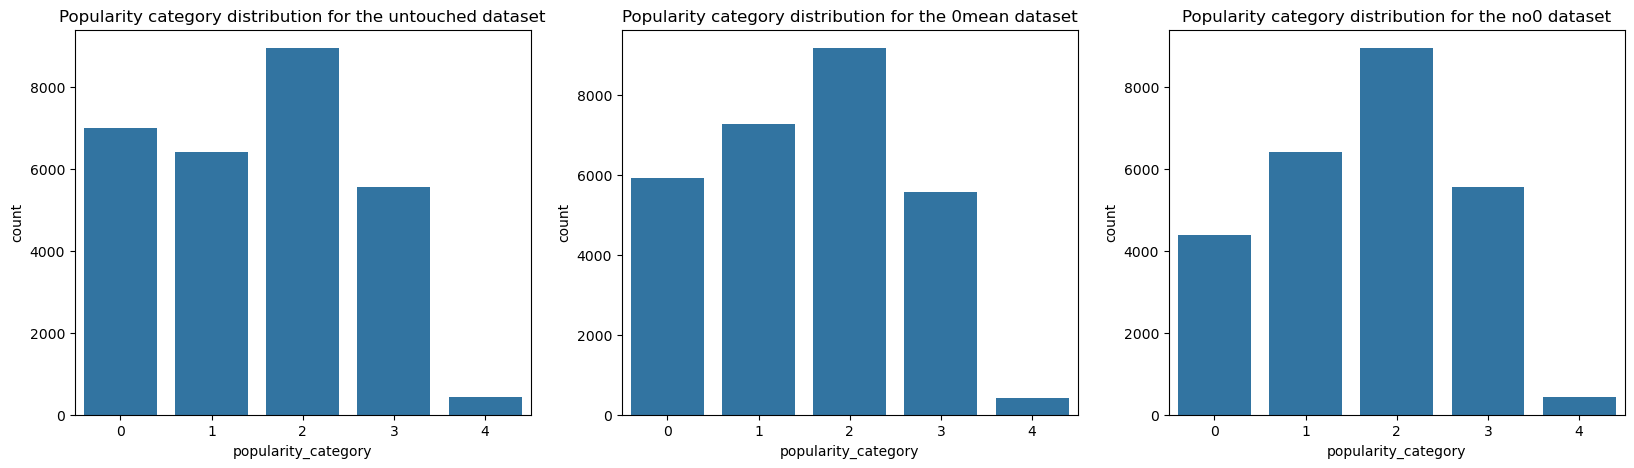

In [87]:
# plot distribution of popularity categories

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(x='popularity_category', data=df_nothing, ax=ax[0])
ax[0].set_title('Popularity category distribution for the untouched dataset')

sns.countplot(x='popularity_category', data=df_0mean, ax=ax[1])
ax[1].set_title('Popularity category distribution for the 0mean dataset')

sns.countplot(x='popularity_category', data=df_no0, ax=ax[2])
ax[2].set_title('Popularity category distribution for the no0 dataset')

plt.show()

### DecisionTree

In [88]:
results = []

**Do nothing dataset**

In [89]:
# train a decision tree classifier on the dataset
train_accuracy_nothing = []
test_accuracy_nothing = []
for depth in depths:
    clf_nothing = DecisionTreeClassifier(max_depth=depth)
    clf_nothing.fit(X_train_nothing, y_train_nothing)
    
    train_accuracy_nothing.append(accuracy_score(y_train_nothing, clf_nothing.predict(X_train_nothing)))
    test_accuracy_nothing.append(accuracy_score(y_test_nothing, clf_nothing.predict(X_test_nothing)))
    

**0mean dataset**

In [90]:
train_accuracy_0mean = []
test_accuracy_0mean = []
for depth in depths:
    clf_0mean = DecisionTreeClassifier(max_depth=depth)
    clf_0mean.fit(X_train_0mean, y_train_0mean)
    
    train_accuracy_0mean.append(accuracy_score(y_train_0mean, clf_0mean.predict(X_train_0mean)))
    test_accuracy_0mean.append(accuracy_score(y_test_0mean, clf_0mean.predict(X_test_0mean)))

**No 0 dataset**

In [91]:
train_accuracy_no0 = []
test_accuracy_no0 = []
for depth in depths:
    clf_no0 = DecisionTreeClassifier(max_depth=depth)
    clf_no0.fit(X_train_no0, y_train_no0)
    
    train_accuracy_no0.append(accuracy_score(y_train_no0, clf_no0.predict(X_train_no0)))
    test_accuracy_no0.append(accuracy_score(y_test_no0, clf_no0.predict(X_test_no0)))

**Plot the results**

Text(0.5, 0, 'Max depth')

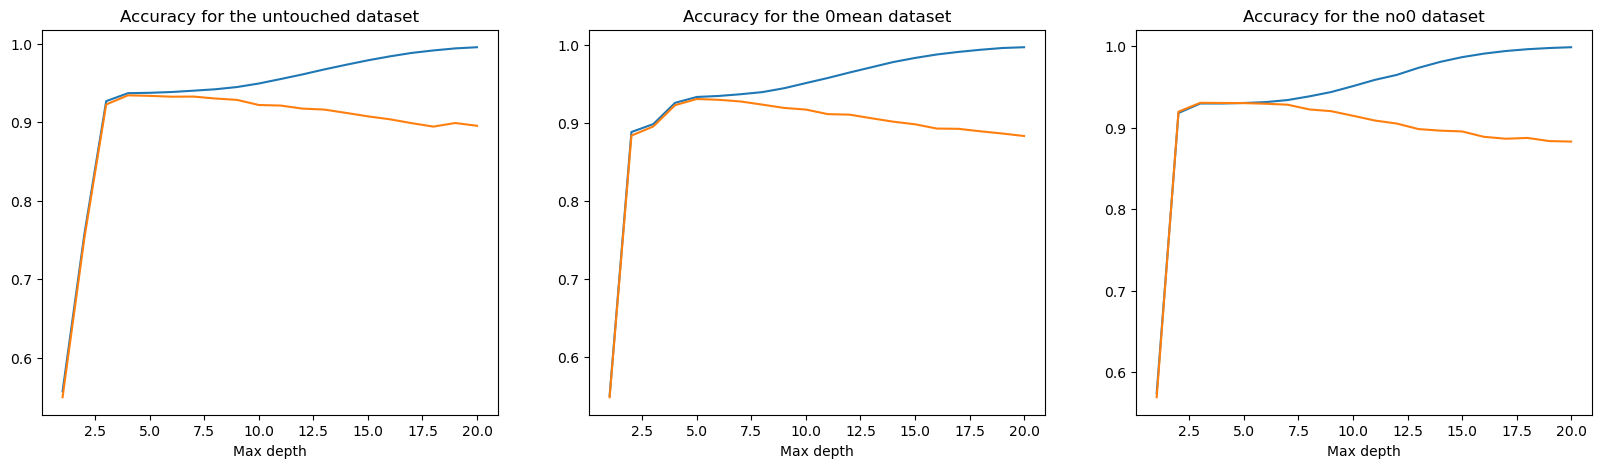

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(depths, train_accuracy_nothing, label='train')
ax[0].plot(depths, test_accuracy_nothing, label='test')
ax[0].set_title('Accuracy for the untouched dataset')
ax[0].set_xlabel('Max depth')

ax[1].plot(depths, train_accuracy_0mean, label='train')
ax[1].plot(depths, test_accuracy_0mean, label='test')
ax[1].set_title('Accuracy for the 0mean dataset')
ax[1].set_xlabel('Max depth')

ax[2].plot(depths, train_accuracy_no0, label='train')
ax[2].plot(depths, test_accuracy_no0, label='test')
ax[2].set_title('Accuracy for the no0 dataset')
ax[2].set_xlabel('Max depth')   

**Find the best result for each dataset**

In [93]:
best_result_nothing = max(test_accuracy_nothing)
best_depth_nothing = depths[test_accuracy_nothing.index(best_result_nothing)]

results.append(["Decision Tree", "Untouched", best_result_nothing, best_depth_nothing])

best_result_0mean = max(test_accuracy_0mean)
best_depth_0mean = depths[test_accuracy_0mean.index(best_result_0mean)]

results.append(["Decision Tree", "0mean", best_result_0mean, best_depth_0mean])

best_result_no0 = max(test_accuracy_no0)
best_depth_no0 = depths[test_accuracy_no0.index(best_result_no0)]

results.append(["Decision Tree", "no0", best_result_no0, best_depth_no0])

**Results**

In [95]:
col = ["Model", "Dataset", "Accuracy", "Best Depth"]

pd.DataFrame(results, columns=col)

,Model,Dataset,Accuracy,Best Depth
0,Decision Tree,Untouched,0.934050,4
1,Decision Tree,0mean,0.931053,5
2,Decision Tree,no0,0.930458,3
